In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import batman
import lightkurve
from lightkurve.lightcurve import LightCurve
astropy.units as u
astropy.constants as c

# Bayes' Theorem:

# $P(\theta|D) = \frac{P(D|\theta)P()}{P(B)}$

P($\theta$|D) is the posterior, the probability of a set of model parameters ($\theta$) given our data (D),

P(D|$\theta$) is the likelihood, it basically says how well a given model with parameters, $\theta$, fits the data - 

P($\theta$) is the prior, our prior belief in the model parameters. This is usually based on what boundaries you think are physically reasonable for the system. Priors can be uniform (equal probability for all parameter values), gaussian, poisson, etc 

P(D) is the probability of the data (usually this is very difficult or impossible to calculate, so we marginalize over it)

# Markov-Chain Monte Carlo

This is a process by which you can sample probability space as it is explored by "walkers" in order to generate a sample of the "true" posterior distribution without the computation time requirement of exploring the entirety of probability space.

Basically this is how we are calculating huge amounts of the likelihood of multi-dimensional parameter space

# Let's simulate some transit data...

rp = 1 Rearth

rs = 0.2 Rsun

period = 5 days

In [4]:
def BATMAN_MODEL(baseline, rp, rs = 0.2, period = 10.0, t0=0, t = None):
    
    rp_rs = (rp/rs)*(1/109) #conversion from rearth and rsun to into unitless rp/r* using earth-sun ratio 
    
    params = batman.TransitParams()
    params.t0 = t0                      #time of inferior conjunction
    params.per = period                 #period in hours
    params.rp = rp_rs                   #planet radius (in units of stellar radii)
    params.a = 30                       #semi-major axis (in units of stellar radii)
    params.inc = 90                     #orbital inclination (in degrees)
    params.ecc = 0                      #eccentricity
    params.w = 90                       #longitude of periastron (in degrees)
    params.u = [0.1956, 0.3700]         #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"      #limb darkening model
        
    m = batman.TransitModel(params, t)    #initializes model
    
    flux = m.light_curve(params)*baseline       #calculates light curve
    
    return flux

In [3]:
start_hr = -3.0
stop_hr = 3.0
length = 300

times = np.linspace(start_hr,stop_hr,length)
data = BATMAN_MODEL(baseline = 1.0, rp = 1.0, t0=0, t = times)
noise = np.random.normal(1,0.02,length)

plt.figure(figsize=(10,8))
plt.errorbar(times,sim,yerr=errors,fmt='o',alpha=0.4,label='Observed by Sinistro')
plt.errorbar(times,sim_muscat,yerr=errors_muscat,fmt='o',alpha=0.6,c='k',zorder=100,
            label = 'Observed by MusCAT3')
plt.plot(times,data,color='red',zorder=10000)
plt.legend(loc='lower left')
plt.xlabel('Time from mid-transit (hr)')
plt.savefig('Figs/noise_model.pdf')
plt.show()

TypeError: BATMAN_MODEL() got an unexpected keyword argument 'Baseline'

In [5]:
print(noise)

0.0012975610664824862


Define the log probability, using Gaussian priors

In [6]:
def lnprob(parameters, plot=False,extra_mods=False,Title='',Rp_best=0,Rp_diff=0,t0_best=0,t0_diff=0):
        
    # pull out some model parameters
    Baseline, Rp, t0 = parameters
    
    flux = BATMAN_MODEL(Baseline, Rp, t0, t = times)
    
    if plot:
        plt.errorbar(times,sim,yerr=errors,fmt='o',alpha = 0.5,label='Simulated Data')
        plt.plot(times,flux,label='MCMC Model',color='k',zorder=100)
        plt.xlabel('Hours from Mid-Transit')
        plt.ylabel('Flux')
        plt.text(1,0.996,'Rp={}$\pm${}'.format(Rp_best,Rp_diff)+' R$_{\otimes}$')
        plt.text(1,0.995,'t$_0$={}$\pm${}'.format(t0_best,t0_diff)+' hours')
        plt.suptitle(Title)
        
        if extra_mods:
            y1 = BATMAN_MODEL(Baseline, Rp, t0+t0_diff, t = times)
            y2 = BATMAN_MODEL(Baseline, Rp, t0-t0_diff, t = times)
            plt.fill_between(times,y1,y2,label='1-$\sigma$ Models',alpha=0.5,color='red',zorder=100)
            y1 = BATMAN_MODEL(Baseline, Rp+Rp_diff, t0, t = times)
            y2 = BATMAN_MODEL(Baseline, Rp-Rp_diff, t0, t = times)
            plt.fill_between(times,y1,y2,alpha=0.5,color='red',zorder=100)
        plt.legend(frameon=False)    
        plt.savefig('LightCurve_Simulation.pdf')   
        plt.show()
    
    # this is a Gaussian likelihood, for independent data points
    
    if (0.0 < Baseline) and (0.0 <= Rp) and (-3.0 < t0 < 3.0 ):
        chisq = np.sum((sim - flux)**2/(errors)**2)
        lnp = np.sum(1/np.sqrt(2*np.pi*(errors))) - 0.5*chisq
    
        return lnp
    
    return -np.inf

Test that the lnprob, with a given set of (true) parameters, returns the expected model.

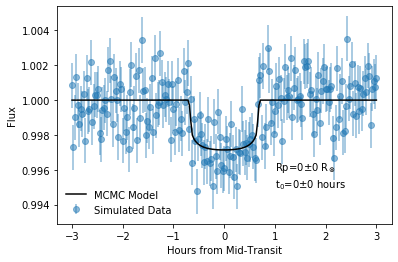

2222.2605163709895


In [7]:
params = [1.0,1.0,0.0]
a = lnprob(params,plot=True)
print(a)

In [430]:
# intialize some walkers
ndim, nwalkers, nsteps = 3, 100, 5000

# these are initial parameters
Base_initial = np.random.uniform(0.5, 1.5, nwalkers)
Rp_initial = np.random.uniform(1, 5, nwalkers)
t0_initial = np.random.uniform(-0.05, 0.05, nwalkers)

p0 = np.transpose([Base_initial, Rp_initial, t0_initial])

In [431]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
result = sampler.run_mcmc(p0, nsteps)

In [432]:
def plot_chain(start=0, stop=nsteps):
    '''Plot the chain, in a couple different ways.'''

    Base, Rp, t0 = sampler.chain.T
    Base_trimmed, Rp_trimmed, t0_trimmed = sampler.chain.T[:, start:stop, :]

    plt.figure(figsize=(14,14))
    gs = plt.matplotlib.gridspec.GridSpec(4,2, hspace=0.6)
    
    #Walker Plots
    ax_Base = plt.subplot(gs[0,0])
    ax_Base.plot(Base.flatten()[::nwalkers],color='black',alpha=0.5); 
    ax_Base.axvspan(start, stop, zorder=-1,alpha=0.3); 
    ax_Base.set_ylabel('Baseline Flux')
    
    ax_Rp = plt.subplot(gs[0,1], sharex=ax_Base)
    ax_Rp.plot(Rp.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_Rp.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_Rp.set_ylabel('Rp')
    
    ax_t0 = plt.subplot(gs[1,0], sharex=ax_Base)
    ax_t0.plot(t0.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_t0.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_t0.set_ylabel('Mid-Transit Time (hr)')
    
    #Histograms
    ax_Basehist = plt.subplot(gs[1,1])
    ax_Basehist.hist(Base.flatten(),color='black',bins=60)
    ax_Basehist.axvline(1.0,zorder=100,color='purple')
    ax_Basehist.set_xlabel('Baseline')
    
    ax_Rphist = plt.subplot(gs[2,0])
    ax_Rphist.hist(Rp.flatten(),color='black',bins=60)
    ax_Rphist.axvline(1,zorder=100,color='purple')
    ax_Rphist.set_xlabel('Rp')
    
    ax_t0hist = plt.subplot(gs[2,1])
    ax_t0hist.hist(t0.flatten(),color='black',bins=60)
    ax_t0hist.axvline(0,zorder=100,color='purple')
    ax_t0hist.set_xlabel('Mid-Transit')
    
    #Scatter Plots
    ax_both = plt.subplot(gs[3,0])
    ax_both.scatter(Base_trimmed, Rp_trimmed, s=5, alpha=0.1)
    ax_both.set_title('{} to {}'.format(start, stop))
    ax_both.set_xlabel('Baseline')
    ax_both.set_ylabel('Rp')
    
    ax_both = plt.subplot(gs[3,1])
    ax_both.scatter(t0_trimmed, Rp_trimmed, s=5, alpha=0.1)
    ax_both.set_title('{} to {}'.format(start, stop))
    ax_both.set_xlabel('Mid-Transit')
    ax_both.set_ylabel('Rp')
    
#    plt.savefig('MCMC_Simulated_Data.png')

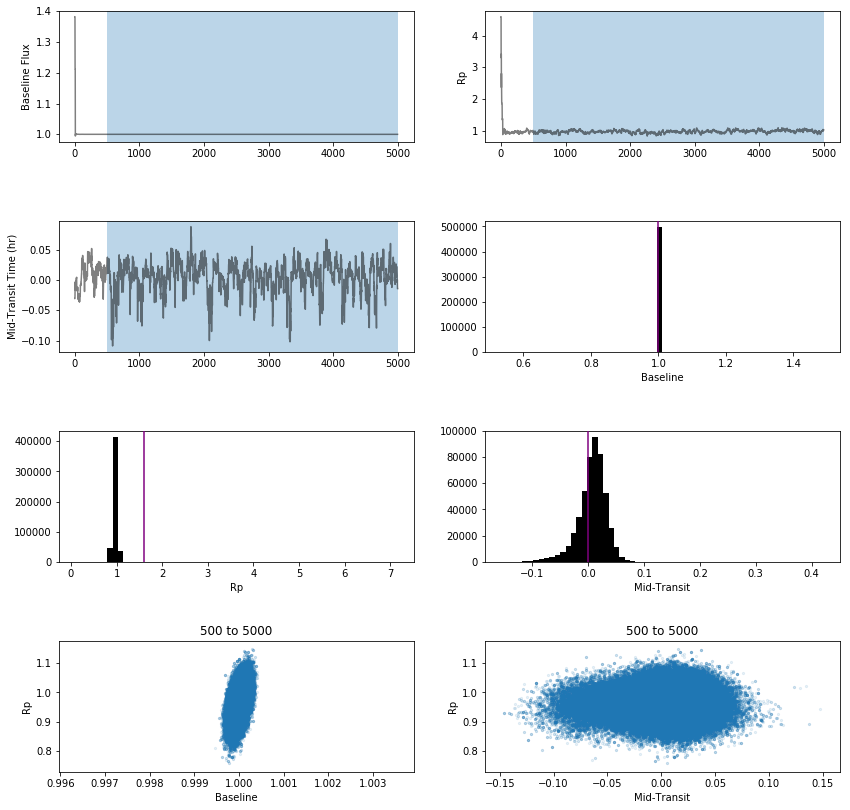

In [433]:
plot_chain(500,5000)

In [434]:
Base, Rp, t0 = sampler.chain.T

sig1_Rp = np.percentile(Rp, [16., 50., 84.])
print(sig1_Rp)
sig1_Base = np.percentile(Base, [16., 50., 84.])
print(sig1_Base)
sig1_t0 = np.percentile(t0, [16., 50., 84.])
print(sig1_t0)

[0.92629816 0.96942846 1.01135493]
[0.99988983 0.99999297 1.00009549]
[-0.0146331   0.01015457  0.02925185]
